In [15]:
BATCH_SIZE = 8

log_to_tb = False

using_res = True

using_colab = False

NET_NAME = 'res18_25.pth'
BEST_NET_NAME = 'res18_25_best.pth'
RUNS_NAME = 'res'

In [2]:
%%html
<style>
table {float:left}
</style>

#### Colab function to add in browser console to stay alive

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

In [ ]:
if using_colab: #put all on runs to make download easier
    SAVE_PATH = './runs/' + NET_NAME
    SAVE_PATH2 = './runs/' + BEST_NET_NAME
    RUNS_PATH = './runs/' + RUNS_NAME
else:
    SAVE_PATH = 'trained/' + NET_NAME
    SAVE_PATH2 = 'trained/' + BEST_NET_NAME
    RUNS_PATH = 'runs/' + RUNS_NAME

In [3]:
if using_colab:
    import tensorflow as tf
    tf.test.gpu_device_name()
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if using_colab:
    train_path = './gdrive/MyDrive/data/car_brand_logos/Train/'
    test_path = './gdrive/MyDrive/data/car_brand_logos/Test/'
else:
    train_path = 'data/car_brand_logos/Train/'
    test_path = 'data/car_brand_logos/Test/'

## Data analysis:

### Train set

| Label name | | Number of images |
| - | | - | 
| hyundai | | 302 | 
| lexus | | 301 | 
| mazda | | 316 | 
| mercedes | | 342 | 
| opel | | 301 | 
| skoda | | 314 | 
| toyota | | 306 | 
| volkswagen | | 330 | 

### Test set
| Label name | | Number of images |
| - | | - | 
| hyundai | | 50 | 
| lexus | | 50 | 
| mazda | | 50 | 
| mercedes | | 50 | 
| opel | | 50 | 
| skoda | | 50 | 
| toyota | | 50 | 
| volkswagen | | 50 | 

In [5]:
%matplotlib inline

### Imports

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize, Compose
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image
from PIL.features import pilinfo

from copy import deepcopy


import traceback
import warnings
warnings.filterwarnings("error")

### Useful functions to retrive the data

In [7]:
# create a annotations_file.csv (index -> img (name), label (int))

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [8]:
# create the pool of images (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # cnt = 0
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
            # cnt += 1
        # print(f"Label: {d} - Number: {cnt}")
    
    return pd.Series(ret)

In [9]:
# convert a given format image hidden in JPG format, converting it to a JPG and overwriting the original with its format (WEBP or PNG)

def convertPNGImage(path, start_format):
    img = Image.open(path, formats=[start_format])
    new_path = path[:-3] + 'jpg'
    img.convert('RGB').save(new_path)
    image = Image.open(new_path, formats=['JPEG'])
    return image    

# Defining the custom dataset (structure that holds the data)

### old version

In [10]:
if not using_res:
    wrong_images_path = []
    

    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
                if Image.MIME[image.format] == 'image/webp': #wrong format, we want only jpg
                        image = convertPNGImage(self.images.loc[idx][0], 'WEBP')
            # except UserWarning:
            #     print('Found exif error at {} in position {}'.format(self.images.loc[idx][0], idx))
            #     wrong_images_path.append('EXIF '+self.images.loc[idx][0])
            except Exception:
                print('Found error at {} in position {}'.format(self.images.loc[idx][0], idx))                
                # wrong_images_path.append(self.images.loc[idx][0])
            image = ToTensor()(image)
            
            if image.shape[0] >= 3: #apply grayscale to colored img
                image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
            else: #we have a greyscaled image, move it into tensor 
                image = to_tensor(ToPILImage()(image))

            image = Resize((300, 300))(image)
            #data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0]
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20
                    #print (f'Rotate: {angle}')
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0]
                if fr == 1: 
                    image = hflip(image)

            #image = image.permute(1,2,0) #made to be shown on matplotlib
            label = self.img_labels.loc[idx][1]
            #if self.transform:
            #    image = self.transform(image)
            #if self.target_transform:
            #    label = self.target_transform(label)

            return image, label

### new version (resnet)

In [11]:
if using_res:
    wrong_images_path = []

    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
                # exif_data = image._getexif()
                if Image.MIME[image.format] == 'image/png': #wrong format, we want only jpg
                        image = convertPNGImage(self.images.loc[idx][0], 'PNG')
            # except UserWarning:
            #     print('Found exif error at {} in position {}'.format(self.images.loc[idx][0], idx))
            #     wrong_images_path.append('EXIF '+self.images.loc[idx][0])
            except Exception:
                print('Found exif error at {} in position {}'.format(self.images.loc[idx][0], idx))
                # wrong_images_path.append(self.images.loc[idx][0])
                
            image = ToTensor()(image)
            
            if image.shape[0] != 3: #color grayscaled and convert RGBA
                image = ToPILImage()(image).convert('RGB')
                
            else: #rgb, don't touch it 
                image = ToPILImage()(image)
                
            preprocess = Compose([
                Resize((400, 400)),
                CenterCrop((400, 400)),
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = preprocess(image)
            
            
            #  COMMENT ME
            # print(f"idx: {idx} - path: {self.images.loc[idx][0]}")
            
            
            
            #data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0]
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20
                    #print (f'Rotate: {angle}')
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0]
                if fr == 1: 
                    image = hflip(image)

            label = self.img_labels.loc[idx][1]

            return image, label

### Creating the 2 dataset and testing

In [12]:
# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=True)

test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'train dataset: {train_data.__len__()}')
print (f'test dataset: {test_data.__len__()}')

train dataset: 2512
test dataset: 400


In [13]:
# for i in range(train_data.__len__()):
#     img, label = train_data[i]

# for i in range(test_data.__len__()):
#     img, label = test_data[i]
    
    
# display(wrong_images_path)
# print(len(wrong_images_path))

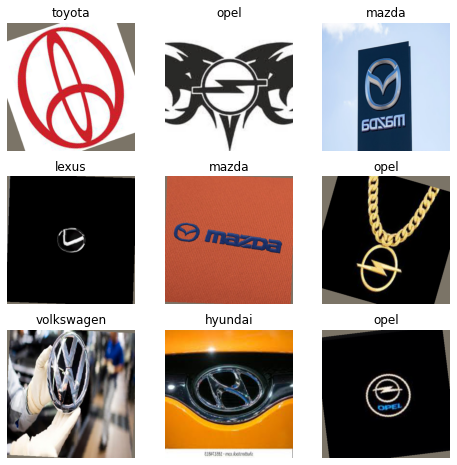

In [14]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    if using_res:
        img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    # img = ToPILImage(img)
    # print(img)
    # print (img.shape, img.dtype, label)
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    if not using_res:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()

In [14]:
# img1, lab1 = train_data[2040]

# img1 = img1 * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
# plt.imshow(img1.permute(1,2,0))

# name = './data/car_brand_logos/Train/toyota/images283.jpg'
# new_name = name[:-3] + 'png'
# os.rename(name, new_name)

# print(f"img shape: {img1.size()}")

# img_pil = ToPILImage()(img1)
# img_channels = Image.Image.split(img_pil)

# fig, axs = plt.subplots(figsize=(20,8), nrows=1, ncols=4)
# axs[0].imshow(img1.permute(1,2,0))
# cmaps = ['Reds', 'Greens', 'Blues']
# for i in range(1,4):
#     axs[i].imshow(img_channels[i-1], cmap=cmaps[i-1])

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([8, 3, 400, 400])
Labels batch shape: torch.Size([8])


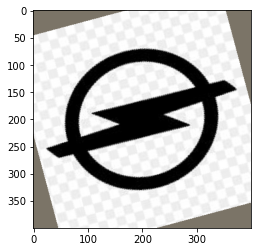

Label: opel


In [15]:
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0]#picking the first img and label of the batch
label = labels[0]
if not using_res:
    plt.imshow(img.squeeze(), cmap='gray')
else:
    if using_res:
        img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()
print(f"Label: {diz[label.item()]}")

In [16]:
labels

tensor([4, 6, 4, 6, 2, 0, 0, 3])

### Defining the neural network

In [17]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [19]:
if not using_res:
    class Net(nn.Module):

        def __init__(self):
            super(Net, self).__init__()

            #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
            self.conv1 = nn.Conv2d(1, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)        
            self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
            self.fc_layer2 = nn.Linear(120, 84)
            self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

        def forward(self, x):
            # Max pooling over a (2, 2) window
            x = self.pool(F.relu(self.conv1(x)))
            #print ('conv1', x.shape)
            # If the size is a square, you can specify with a single number
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
            #print ('flatten', x.shape)
            x = F.relu(self.fc_layer1(x))
            x = F.relu(self.fc_layer2(x))
            x = self.fc_layer3(x)
            return x
        
    net = Net()
    net.to(device)

In [20]:
if using_res:
    net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    net.to(device)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


In [21]:
#test
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

62
torch.Size([64, 3, 7, 7])


In [22]:
# loss function
criterion = nn.CrossEntropyLoss()
# use gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  #overwrite params if using pretrained net
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

### Tensorboard setup

start tensorboard: `tensorboard --logdir=Users\eliad\Tesi\ProgettoTesi\runs\car_brands_1`

In [23]:
if log_to_tb:
    writer = SummaryWriter(RUNS_PATH)

    # get some random training images
    dataiter = iter(train_dl)
    images, labels = dataiter.next()

    #visualizing and adding images into tb
    for idx in range(4):    
        img = images[idx]
        # plt.imshow(img.squeeze(), cmap='gray')
        # plt.imshow(img.permute(1,2,0)) #use this if rbg
        # plt.show()
        # print (img.shape, img.dtype)
        writer.add_image(f"car_brands_images_{idx+1}", img)

    ### Adding the graph of the network into Tensorboard

    writer.add_graph(net, images.to(device))

    ### Adding the projector 

#     tmp_dl = DataLoader(train_data, batch_size=100, shuffle=True)
#     images, labels = next(iter(tmp_dl))

#     # get the class labels for each image
#     class_labels = [diz[lab.item()] for lab in labels]
    
    
#     print(len(class_labels))
#     print(len(labels))
#     print(images.size())


#     images = Resize((28, 28))(images)

#     features = images.view(-1, 28 * 28)
    #this should be something [100, ...] to equal the dim of the labels, with rgb got 300
    # writer.add_embedding(features,
    #                     metadata=class_labels,
    #                     label_img=images)

torch.Size([3, 400, 400]) torch.float32
torch.Size([3, 400, 400]) torch.float32
torch.Size([3, 400, 400]) torch.float32
torch.Size([3, 400, 400]) torch.float32


### Confusion matrix during training

In [24]:
def createConfusionMatrix(loader, netw):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = netw(inputs.to(device))  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = diz.values()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    #normalization
    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    df_cm = pd.DataFrame(cmn, index=[i for i in classes],
                         columns=[i for i in classes])
    fig = plt.figure(figsize=(8, 8), dpi=125)
    sn.heatmap(df_cm, annot=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    im = Image.open(buf)
    im = ToTensor()(im)
    plt.close(fig)
    return im

### Training the network

In [25]:
print(next(net.parameters()).device)

cuda:0


In [26]:
best_accuracy = 0
for epoch in range(25):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dl):
        # get the inputs; data is a list of [inputsdeviceels]
        inputs, labels = data
        batch_len = len(labels)
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print (oudpi=ts.device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        skip = 50
        if i > 0  and i % 50 == 0:    # print every 360 images (8 images per batch, 45 loops)
            # ...log the running loss
            if log_to_tb:
                writer.add_scalar('training loss',
                               running_loss / skip,
                               (epoch * len(train_data)) + (i * batch_len))
            running_loss = 0.0
    
    print(f'[{epoch + 1}, {i}/{len(train_dl)}] loss: {(running_loss/skip):.3f}')
    scheduler.step()

    #end of an epoch, calculate loss on test set (since it's small and there's no need to split)
    with torch.no_grad():
        net.eval()
        test_loss = 0
        test_acc = 0
        test_total = 0
        for _, data in enumerate(test_dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.permute(0, 3, 1, 2)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0) 
            test_acc += (predicted == labels).sum().item() 
            
        actual_test_loss = test_loss/len(test_dl)
        accuracy = (100 * test_acc / test_total) 
        
        print(f"[{epoch + 1}] test loss: {(actual_test_loss):.3f} , test acc: {accuracy}")
        if log_to_tb:
            writer.add_scalar('test loss',
                           actual_test_loss,
                           epoch+1)
            writer.add_scalar('accuracy',
                           accuracy,
                           epoch+1)
            # confusion matrix (added from extra step)        
            writer.add_image(f"confusion_matrix at epoch {epoch+1}", createConfusionMatrix(test_dl, net), global_step=epoch)

        # here check for the metric you want to improve (not necessarily the loss) and hence
        # the model you want to keep, e.g., accuracy
        if accuracy > best_accuracy:
           best_accuracy = accuracy
           torch.save(net.state_dict(), SAVE_PATH2)
        

print('Finished Training')
print(f"best accuracy: {best_accuracy:.3f}")

[1, 50/315] loss: 3.592
[1, 50/315] loss: 0.000
[1, 100/315] loss: 2.145
[1, 100/315] loss: 0.000
[1, 150/315] loss: 2.199
[1, 150/315] loss: 0.000
[1, 200/315] loss: 2.107
[1, 200/315] loss: 0.000
[1, 250/315] loss: 2.122
[1, 250/315] loss: 0.000
[1, 300/315] loss: 2.094
[1, 300/315] loss: 0.000
[1] test loss: 2.563 , test acc: 22.0
[2, 50/315] loss: 2.115
[2, 50/315] loss: 0.000
[2, 100/315] loss: 2.060
[2, 100/315] loss: 0.000
[2, 150/315] loss: 2.019
[2, 150/315] loss: 0.000
[2, 200/315] loss: 2.076
[2, 200/315] loss: 0.000
[2, 250/315] loss: 2.018
[2, 250/315] loss: 0.000
[2, 300/315] loss: 1.963
[2, 300/315] loss: 0.000
[2] test loss: 2.364 , test acc: 27.0
[3, 50/315] loss: 1.967
[3, 50/315] loss: 0.000
[3, 100/315] loss: 1.943
[3, 100/315] loss: 0.000
[3, 150/315] loss: 1.894
[3, 150/315] loss: 0.000
[3, 200/315] loss: 1.926
[3, 200/315] loss: 0.000
[3, 250/315] loss: 1.917
[3, 250/315] loss: 0.000
[3, 300/315] loss: 1.866
[3, 300/315] loss: 0.000
[3] test loss: 2.404 , test ac

KeyboardInterrupt: 

In [ ]:
#saving the trained model
torch.save(net.state_dict(), SAVE_PATH)

In [ ]:
if not using_res:
    loaded = Net()
else:
    loaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    
loaded.load_state_dict(torch.load(SAVE_PATH2))
loaded.to(device)
loaded.eval()

In [ ]:
# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(diz[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)

if log_to_tb:
    class_probs = []
    class_label = []
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            output = loaded(images)
            class_probs_batch = [F.softmax(el, dim=0) for el in output]

            class_probs.append(class_probs_batch)
            class_label.append(labels)

    test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
    test_label = torch.cat(class_label)

    # plot all the pr curves
    for i in range(len(diz.values())):
       add_pr_curve_tensorboard(i, test_probs, test_label)
    
if using_colab:
    from google.colab import files
    networks = [ name for name in os.listdir('/content/runs/') if 
                 os.path.isfile(os.path.join('/content/runs/', name)) ]

    runs = ([ name for name in os.listdir('/content/runs/' + RUNS_NAME) if 
                 os.path.isfile(os.path.join('/content/runs/' + RUNS_NAME, name)) ])

    for netw in networks:
      files.download('/content/runs/' + netw)

    for run in runs:
      files.download('/content/runs/' + RUNS_NAME + '/' + run)